# Exploratory data analaysis for FSNAU data

## Set export to True if you wish to export graphs and tables


In [1]:
export = True
seed = 1337


In [2]:
from itertools import product
import warnings
import pickle
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from os import listdir
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from auxiliary_code.helper_functions import *
from auxiliary_code.Interpolation import Interpolation
from auxiliary_code.Clustering import Clustering
import matplotlib.dates as mdate


%matplotlib inline

warnings.simplefilter('ignore')


# Loading data and removing outliers (0.1% filtering)


In [3]:
path = '../datasets/'

df_fsnau = pd.read_csv(path + 'fsnau_processed.csv', parse_dates=['date'])
set_index(df_fsnau)

df_pop = pd.read_csv(path + 'world_bank_processed.csv',
                     usecols=['date', 'area', 'pop'])
set_index(df_pop)

df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')
neighbors_dict = get_neighbour_dict(df_shape)

df_loc = pd.read_csv(path + 'locations_processed.csv').set_index('area')

# df_pop = pd.read_csv(
#     '../datasets/world_bank_processed.csv', parse_dates=['date'], usecols=['date', 'area', 'pop'])
# set_index(df_pop)
# df_pop = df_pop.groupby('area').mean()

#df_fsnau = df_fsnau.join(df_pop)

In [4]:
df_sum = df_fsnau.describe().transpose().iloc[:, 1:]
isna_series = df_fsnau.isna().mean() * 100
isna_series.rename('% missing', inplace=True)
df_sum = df_sum.merge(isna_series, left_index=True, right_index=True)
print(df_sum.round().astype(int).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     mean &      std &     min &      25\% &      50\% &      75\% &      max &  \% missing \\
\midrule
New Admissions (GAM)         &      777 &     1857 &       0 &      100 &      296 &      745 &    35359 &         63 \\
Measles Cases                &       24 &       83 &       0 &        1 &        5 &       16 &     1948 &         77 \\
AWD/cholera cases            &       63 &      241 &       0 &        0 &        3 &       28 &     4106 &         84 \\
AWD/Cholera deaths           &        8 &       13 &       1 &        1 &        3 &        8 &       79 &         99 \\
Malaria Cases                &       72 &      293 &       0 &        2 &       13 &       43 &     8965 &         76 \\
Insecurity - Incidents       &        5 &        9 &       1 &        1 &        3 &        6 &       85 &         71 \\
Insecurity - Fatalities      &        9 &       21 &       0 &        0 &        2 &       10 &      670 &         71 \\
Displacem

# Interpolation


In [5]:
price_columns = ['Price of water', 'Sorghum prices', 'Maize prices', 'Red Rice prices'] + ['Local goat prices', 'Wage labor',
                                                                                           'TOT (goat to cereals)', 'TOT (wage to cereals)',
                                                                                           'Cost of Minimum Basket (CMB)']

interpolation = Interpolation(df_fsnau, price_columns, neighbors_dict)

df_fsnau_int = interpolation.interpolate_spatially()
na_means = interpolation.get_na_means()


[array([0.15189873, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0443038 ])]


# Figures


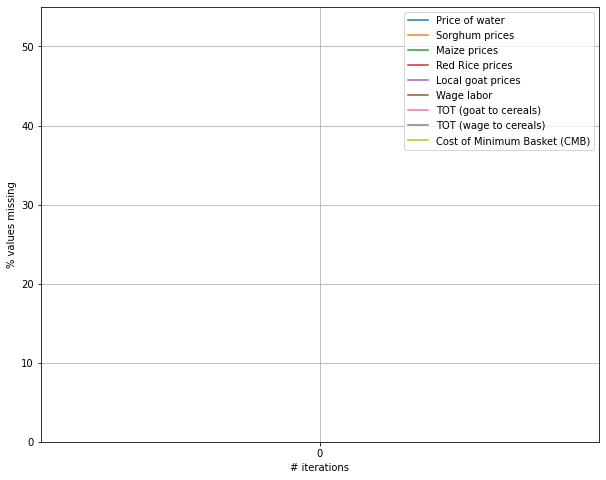

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.array(na_means)*100, label=price_columns)
ax.legend()
ax.set_xlabel('# iterations')
ax.set_ylabel('% values missing')
ax.grid()
ax.set_xlim(0, len(na_means) - 1)
ax.set_xticks(range(len(na_means)))
ax.set_ylim(0, 55)

if export:
    fig.savefig('../Figures/interpolation_convergence.pdf', format='pdf')


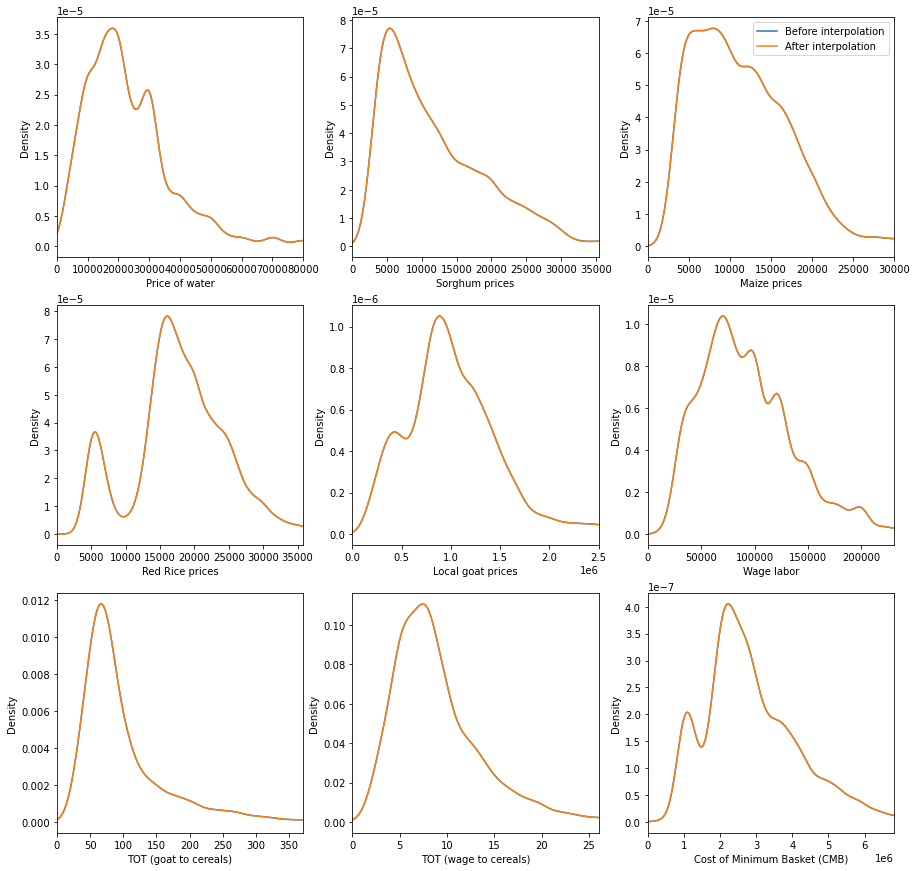

In [7]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)

for i, ax in enumerate(axs.flatten()):
    df_fsnau[price_columns[i]].plot(kind='kde', ax=ax)
    df_fsnau_int[price_columns[i]].plot(kind='kde', ax=ax)
    ax.set_xlabel(price_columns[i])
    ax.set_xlim(0, df_fsnau[price_columns[i]].quantile(0.99))
    if i == 2:
        ax.legend(['Before interpolation', 'After interpolation'])

if export:
    fig.savefig('../Figures/interpolation_kde.pdf', format='pdf')


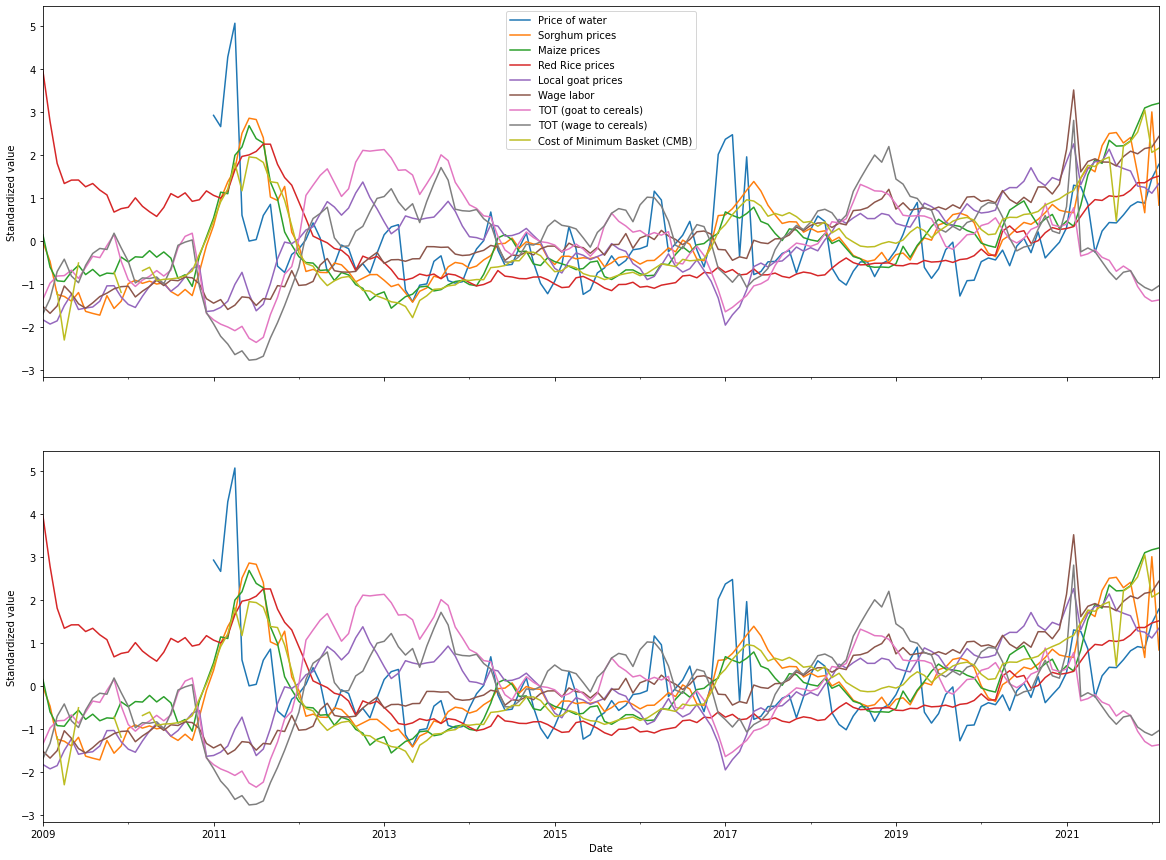

In [8]:
fig, ax = plt.subplots(figsize=(20, 15), nrows=2, sharex=True, sharey=True)

ts = df_fsnau.groupby('date')[price_columns].mean()
((ts - ts.mean())/ts.std()).plot(ax=ax[0])
ts = df_fsnau_int.groupby('date')[price_columns].mean()
((ts - ts.mean())/ts.std()).plot(ax=ax[1])
ax[0].set_ylabel('Standardized value')
ax[1].set_ylabel('Standardized value')
ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[1].get_legend().remove()

if export:
    plt.savefig('../Figures/prices_mean_area_interpolated_temporal.pdf',
                format='pdf', bbox_inches='tight')


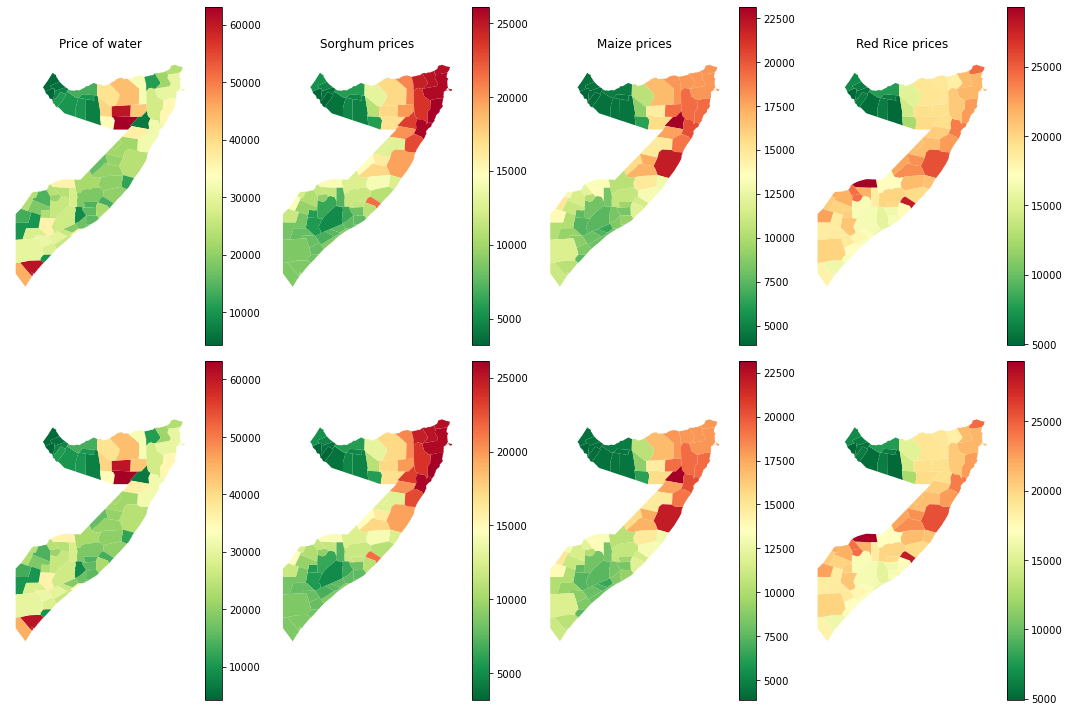

In [9]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))

missing_kwds = {"color": "lightgrey", "label": "Missing values"}
cols = ['Price of water', 'Sorghum prices', 'Maize prices', 'Red Rice prices']

for i, df in enumerate([df_fsnau, df_fsnau_int]):
    df_mean_prices = df.groupby('area')[cols].mean()
    df_plot = df_shape.merge(
        df_mean_prices, left_index=True, right_index=True)
    for j, col in enumerate(cols):
        df_plot.plot(column=col, cmap='RdYlGn_r', legend=True,
                     ax=axs[i, j], missing_kwds=missing_kwds)
        axs[i, j].axis('off')
        axs[0, j].set_title(col)

plt.tight_layout()

if export:
    plt.savefig('../Figures/prices_mean_area_interpolated_spatial.pdf',
                format='pdf', bbox_inches='tight')


In [10]:
df_fsnau_int.to_csv('../datasets/fsnau_processed.csv')

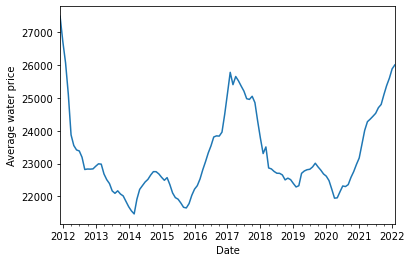

In [12]:
fig, ax = plt.subplots()

df_fsnau.sort_index(inplace=True)
df_fsnau['Price of water'].groupby('area').rolling(12).mean().groupby('date').mean().dropna().plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Average water price')

fig.savefig('../figures/water_prices_12.pdf', format='pdf')

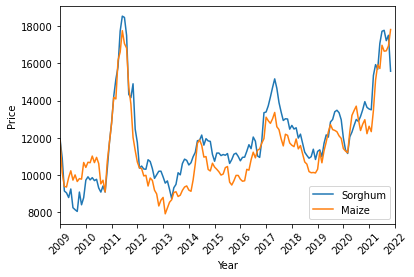

In [27]:
fig, ax = plt.subplots()

df_fsnau['Sorghum prices'].groupby('date').mean().plot()
df_fsnau['Maize prices'].groupby('date').mean().plot()
ax.set_xlabel('Year')
ax.set_ylabel('Price')
ax.legend(['Sorghum', 'Maize'])

ax.set_xticks(range(468, 636, 12))
ax.set_xticklabels(range(2009, 2023))
plt.xticks(rotation=45);

if export:
    fig.savefig('../figures/staple_prices_fsnau.pdf', format='pdf')

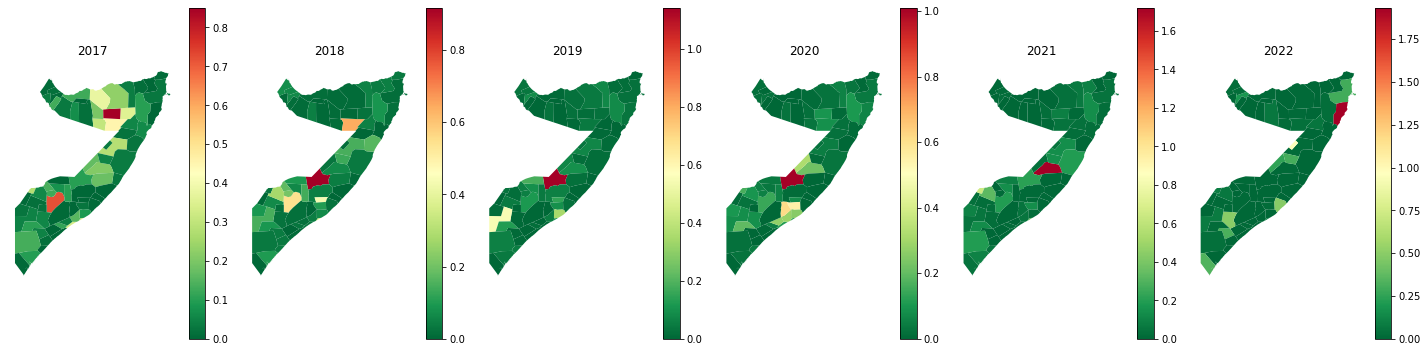

In [38]:
df_fsnau['year'] = get_date(df_fsnau).year
mask = df_fsnau['year'] >= 2017

missing_kwds = {"color": "lightgrey", "label": "Missing values"}

fig, axs = plt.subplots(ncols=6, figsize=(20, 5))

df_fsnau['Displacement (arrivals) normalized'] = df_fsnau['Displacement (arrivals)']/df_fsnau['pop']

for year, df_g in df_fsnau[mask].groupby('year')['Displacement (arrivals) normalized']:
    df_mean_arr_area = df_g.groupby('area').sum()
    df_plot = df_shape.join(df_mean_arr_area)
    df_plot.plot(column='Displacement (arrivals) normalized',
                    cmap='RdYlGn_r', legend=True, ax=axs[year-2017], missing_kwds=missing_kwds)
    
    axs[year-2017].axis('off')
    axs[year-2017].axis('off')
    axs[year-2017].set_title(year)
    
plt.tight_layout()

if export:
    fig.savefig('../figures/displacement_arrivals_pop_norm.pdf', format='pdf')

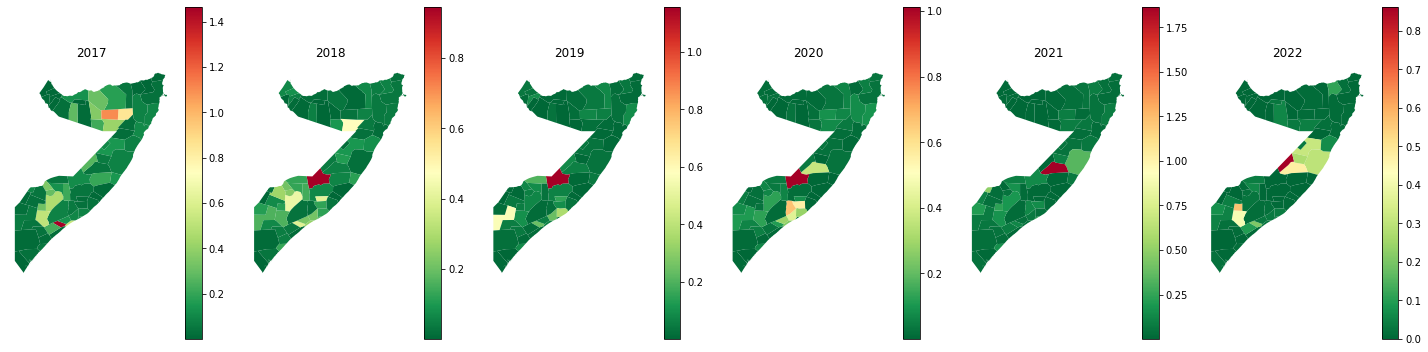

In [39]:
df_fsnau['year'] = get_date(df_fsnau).year
mask = df_fsnau['year'] >= 2017

missing_kwds = {"color": "lightgrey", "label": "Missing values"}

fig, axs = plt.subplots(ncols=6, figsize=(20, 5))

df_fsnau['Displacement (departures) normalized'] = df_fsnau['Displacement (departures)']/df_fsnau['pop']

for year, df_g in df_fsnau[mask].groupby('year')['Displacement (departures) normalized']:
    df_mean_arr_area = df_g.groupby('area').sum()
    df_plot = df_shape.join(df_mean_arr_area)
    df_plot.plot(column='Displacement (departures) normalized',
                    cmap='RdYlGn_r', legend=True, ax=axs[year-2017], missing_kwds=missing_kwds)
    
    axs[year-2017].axis('off')
    axs[year-2017].axis('off')
    axs[year-2017].set_title(year)

plt.tight_layout()

if export:
    fig.savefig('../figures/displacement_departures_pop_norm.pdf', format='pdf')